# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [116]:
n_k1 = 8
n_k2 = 2

n_total = n_k1 + n_k2

p_k1 = n_k1 / n_total
p_k2 = n_k2 / n_total

# Воспользуемся формулой и округлим
entropy = round(- (p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2)), 2)

entropy

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [117]:
# Для R_m
p_k1_m = n_k1 / n_total
p_k2_m = n_k2 / n_total

H_Rm = p_k1_m * (1 - p_k1_m) + p_k2_m * (1 - p_k2_m)

# Для R_l
p_k1_l = 1
p_k2_l = 0

H_Rl = p_k1_l * (1 - p_k1_l) + p_k2_l * (1 - p_k2_l)

# Для R_r
p_k1_r = 0
p_k2_r = 1

H_Rr = p_k1_r * (1 - p_k1_r) + p_k2_r * (1 - p_k2_r)

# Критерий информативности
Q = round(H_Rm - (n_k1 / n_total) * H_Rl - (n_k2 / n_total) * H_Rr, 2)

Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [118]:
# Если берем среднее
values = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
prediction = np.mean(values)

prediction

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [119]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [120]:
# Вспомогательные функции для подсчета хаотичности
def gini(y):
    if y.size == 0:
        return 0
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

def variance(y):
    return np.var(y)

In [121]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    sorted_indices = np.argsort(feature_vector) # Индексы для сортировки
    sorted_features = feature_vector[sorted_indices] # Сортируем и признаки
    sorted_targets = target_vector[sorted_indices] # И объекты по идексам для признаков

    # Посчитаем пороги
    if feature_type == "real":
        # Среднее двух соседних в регрессии
        thresholds = (sorted_features[1:] + sorted_features[:-1]) / 2
    else:
        # Уникальные значения для класиификации
        thresholds = np.unique(sorted_features)

    # Посчитаем меру хаотичности
    if task == "classification":
        overall_metric = gini(sorted_targets)
    else:
        overall_metric = variance(sorted_targets)

    # Чтобы избежать циклов, будем использовать булевые маски
    if feature_type == "real":
        masks = sorted_features[:, None] <= thresholds # Для регрессии: если значение признака <= порогу, то ставится 1, и значение пойдет в левое поддерево, иначе - в правое
    else:
        masks = sorted_features[:, None] == thresholds # Для классификации: значение попадает в левое поддерево, только если оно равно порогу

    # Посчитаем размеры поддеревьев
    left_sizes = masks.sum(axis=0)
    right_sizes = masks.shape[0] - left_sizes

    # Вычислим меры хаотичности
    if task == "classification":
        left_impurities = np.array([gini(np.compress(mask, sorted_targets)) for mask in masks.T]) # Применяем функцию для вычисления меры хаотичности согласно маске
        right_impurities = np.array([gini(np.compress(~mask, sorted_targets)) for mask in masks.T]) # (Здесь - согласно отрицанию маски, то есть для правого поддерева)
    else:
        left_impurities = np.array([variance(np.compress(mask, sorted_targets)) for mask in masks.T])
        right_impurities = np.array([variance(np.compress(~mask, sorted_targets)) for mask in masks.T])

    # Взвешиваем меры хаотичности
    weighted_metrics = (left_sizes * left_impurities + right_sizes * right_impurities) / sorted_features.size

    # Считаем разницы между хаоичностью на предыущем шаге и на текущем
    gains = overall_metric - weighted_metrics

    # Находим лучшее разделение, ура
    best_idx = np.argmax(gains)
    threshold_best = thresholds[best_idx]
    gini_best = gains[best_idx]

    return thresholds, gains, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [122]:
from sklearn.datasets import fetch_california_housing

In [123]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [124]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


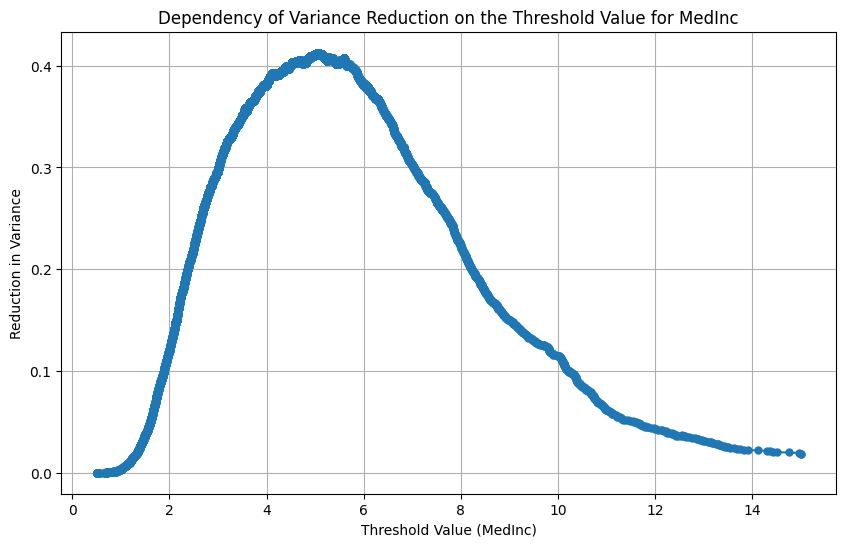

In [125]:
feature_vector = X['MedInc'].values
target_vector = y

thresholds, gains, threshold_best, gini_best = find_best_split(
    feature_vector=feature_vector,
    target_vector=target_vector,
    task="regression",
    feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, gains, marker='o', linestyle='-', markersize=5)
plt.title('Dependency of Variance Reduction on the Threshold Value for MedInc')
plt.xlabel('Threshold Value (MedInc)')
plt.ylabel('Reduction in Variance')
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [126]:
best_gain = -np.inf
best_feature = None
best_threshold = None

for feature in X.columns:
    feature_vector = X[feature].values
    thresholds, gains, threshold_best, gain_best = find_best_split(
        feature_vector=feature_vector,
        target_vector=y,
        task="regression",
        feature_type="real"
    )

    if gain_best > best_gain:
        best_gain = gain_best
        best_feature = feature
        best_threshold = threshold_best

print(f"Лучший признак: {best_feature}")
print(f"Лучший порог: {best_threshold}")
print(f"Прирост информации: {best_gain}")

Лучший признак: AveRooms
Лучший порог: 6.374305146225346
Прирост информации: 0.1592079525892247


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [127]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold_best
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Важность признака!
        n_samples = len(sub_X)
        self._feature_importances[feature_best] = self._feature_importances.get(feature_best, 0) + gini_best * n_samples

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        # Реализовали, получается
        if node['type'] == 'terminal':
            return node['class']
        if self._feature_types[node['feature_split']] == 'real':
            if x[node['feature_split']] <= node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[node['feature_split']] == 'categorical':
            if x[node['feature_split']] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [128]:
df = pd.read_csv('sample_data/students.csv')

df.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


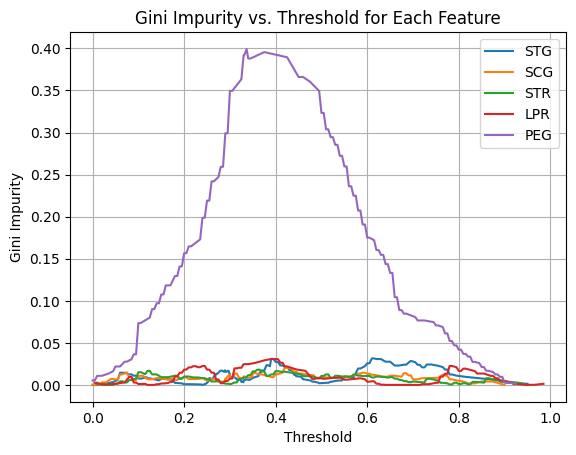

In [129]:
features = df.columns[1:-1]
target = df.columns[-1]

for feature in features:
    feature_vector = df[feature].values
    target_vector = df[target].values
    thresholds, ginis, _, _ = find_best_split(feature_vector, target_vector, task="classification", feature_type="real")

    plt.plot(thresholds, ginis, label=feature)

plt.title('Gini Impurity vs. Threshold for Each Feature')
plt.xlabel('Threshold')
plt.ylabel('Gini Impurity')
plt.legend()
plt.grid(True)
plt.show()

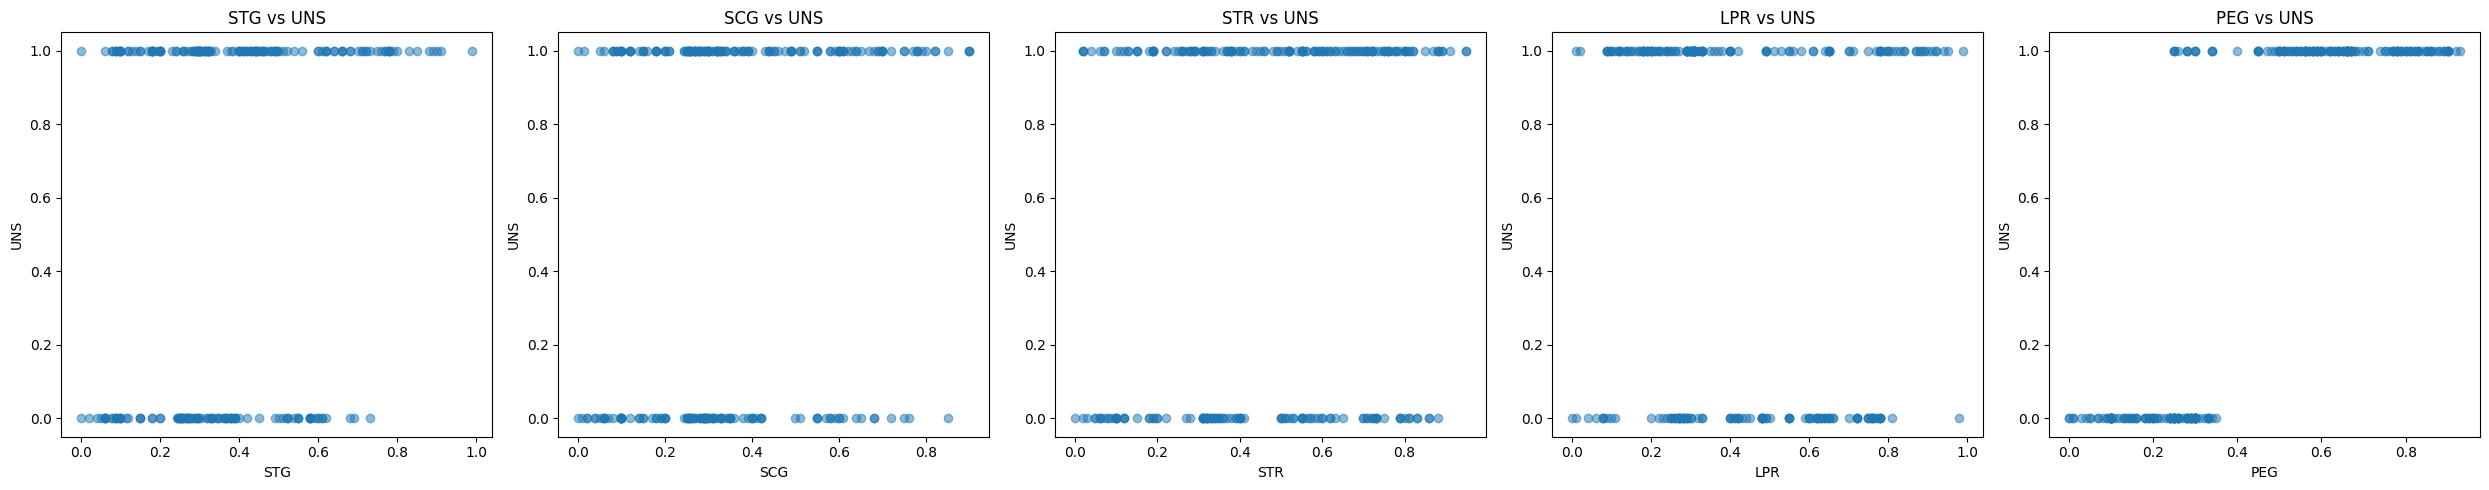

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

for i, feature in enumerate(features):
    axes[i].scatter(df[feature], df[target], alpha=0.5)
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

По графику критерия Джини можно сделать вывод, что признак PEG - хороший кандидат для деления на два поддерева, так как она имеет значительный пик, где значение критерия Джини резко возрастает и затем падает. Это подтверждается и диаграммой рассеяния, где можно заметить соответствующее разделение: при PEG > 0.4 нет отрицательного класса, при PEG < 0.2 нет положительного. В отличие от PEG, другие признаки показывают низкий и равномерный уровень критерия Джини, что показывает равномерное распределение классов по значениям признаков (это видно и на диаграммах рассеяния). Хорошие же кривые имеют значительный пик.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [131]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [132]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None)

label_encoders = {}

for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

print(df.head())

   0   1   2   3   4   5   6   7   8   9   ...  13  14  15  16  17  18  19  \
0   1   5   2   4   1   6   1   0   1   4  ...   2   7   7   0   2   1   4   
1   0   5   2   9   1   0   1   0   0   4  ...   2   7   7   0   2   1   4   
2   0   0   2   8   1   3   1   0   0   5  ...   2   7   7   0   2   1   4   
3   1   5   3   8   1   6   1   0   1   5  ...   2   7   7   0   2   1   4   
4   0   5   2   3   0   5   1   1   0   4  ...   2   7   7   0   2   1   0   

   20  21  22  
0   2   3   5  
1   3   2   1  
2   3   2   3  
3   2   3   5  
4   3   0   1  

[5 rows x 23 columns]


In [133]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

feature_types = ['categorical'] * X_train.shape[1]
decision_tree = DecisionTree(feature_types=feature_types)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

вот бы всегда так...

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [134]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [135]:
data = pd.read_csv('sample_data/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

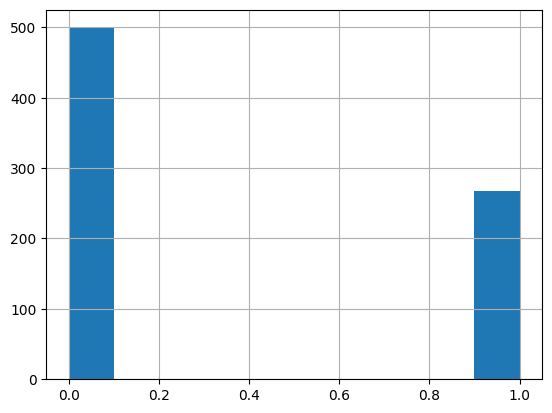

In [136]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [137]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

print(f"Oбучающая-обучающая: {X_train_train.shape[0] / X.shape[0]}, Oбучающая-валидационная: {X_train_val.shape[0] / X.shape[0]}, Tестовая: {X_test.shape[0] / X.shape[0]}")

Oбучающая-обучающая: 0.48828125, Oбучающая-валидационная: 0.2109375, Tестовая: 0.30078125


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [138]:
from sklearn.metrics import f1_score

In [139]:
# Параметры для перебора
max_depth_values = [None] + [i for i in range (1, 50)]
min_samples_leaf_values = [i for i in range (1, 50)]

best_f1 = 0
best_max_depth = None
best_min_samples_leaf = 1

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        # Обучаем модель
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train_train, y_train_train)

        # Смотрим на валидационной выборке
        y_val_pred = dt.predict(X_train_val)

        # Вычисляем f1-меру
        current_f1 = f1_score(y_train_val, y_val_pred)

        # Максимум смотрим
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf

print(f"Best F1 Score: {best_f1}")
print(f"Best max depth: {best_max_depth}")
print(f"Best min samples leaf: {best_min_samples_leaf}")

Best F1 Score: 0.6722689075630253
Best max depth: None
Best min samples leaf: 28


In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [141]:
final_dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=0)
final_dt.fit(X_train, y_train)

y_test_pred = final_dt.predict(X_test)
y_test_proba = final_dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7619
Precision: 0.6338
Recall: 0.6081
AUC-ROC: 0.8018


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [142]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=0
)

bagging_clf.fit(X_train, y_train)

y_test_pred = bagging_clf.predict(X_test)
y_test_proba = bagging_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7792
Precision: 0.6885
Recall: 0.5676
AUC-ROC: 0.8161


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

Источник про ГридСерч: https://habr.com/ru/articles/807605/

In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [144]:
param_grid = {
    'max_depth': [None, 10, 15, 20, 25, 30, 35, 40, 50],
    'min_samples_split': [2, 3, 5, 10, 15, 20, 25, 30]
}

rf = RandomForestClassifier(n_estimators=50, random_state=0)

f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=3; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=3; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=3; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=3; total time=   0.1s
[CV] END ................max_depth=None, min_samples_split=3; total time=   0.2s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.2s
[CV] END ................max_depth=None, min_sa

In [145]:
best_rf = RandomForestClassifier(n_estimators=50, **grid_search.best_params_, random_state=0)
best_rf.fit(X_train, y_train)

y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7706
Precision: 0.7234
Recall: 0.4595
AUC-ROC: 0.8295


| Model          | Accuracy | Precision | Recall | AUC-ROC |
|----------------|----------|-----------|--------|---------|
| Decision Tree  | 0.7619   | 0.6338    | 0.6081 | 0.8018  |
| Bagging        | 0.7792   | 0.6885    | 0.5676 | 0.8161  |
| Random Forest  | 0.7706   | 0.7234    | 0.4595 | 0.8295  |

В целом, все модели показали себя примерно одинаково, если судить по Accuracy и AUC-ROC (виден очень небольшой увеличивающийся градиент от дерева к лесу по AUC-ROC, а вот наибольшая Accuracy у бэггинга). Интересно, что двигаясь от дерева к лесу, Precision падает, а Accuracy растет, то есть число ложноположительных уменьшается, а вот число ложноотрицательных растет.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

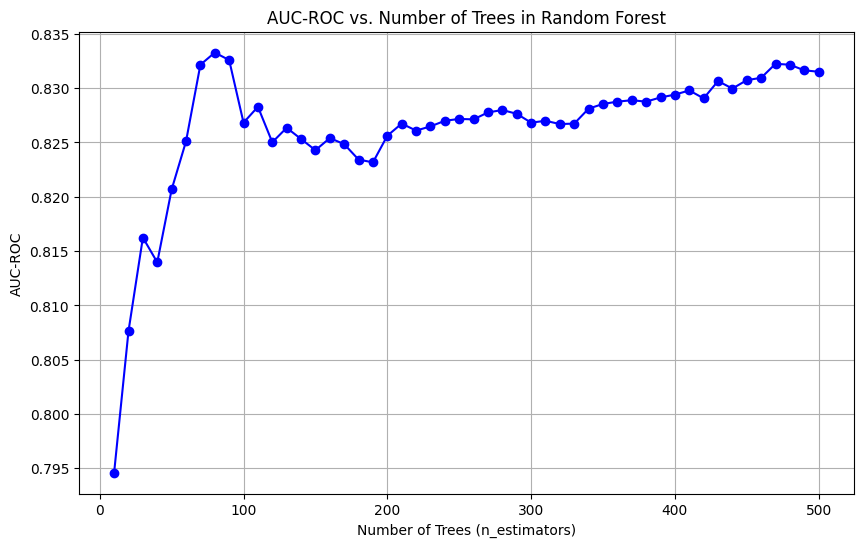

In [146]:
n_estimators_range = [i for i in range(10, 501, 10)]

auc_roc_scores = []

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_roc_scores, marker='o', linestyle='-', color='b')
plt.title('AUC-ROC vs. Number of Trees in Random Forest')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('AUC-ROC')
plt.grid(True)
plt.show()

Лучшим числом деревьев является что-то около 80, затем немного проседает и вновь возвращается к пиковым значениям. В целом, можем подтвердить, что случайный лес не переобучается при увеличении числа дереьев в нем.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

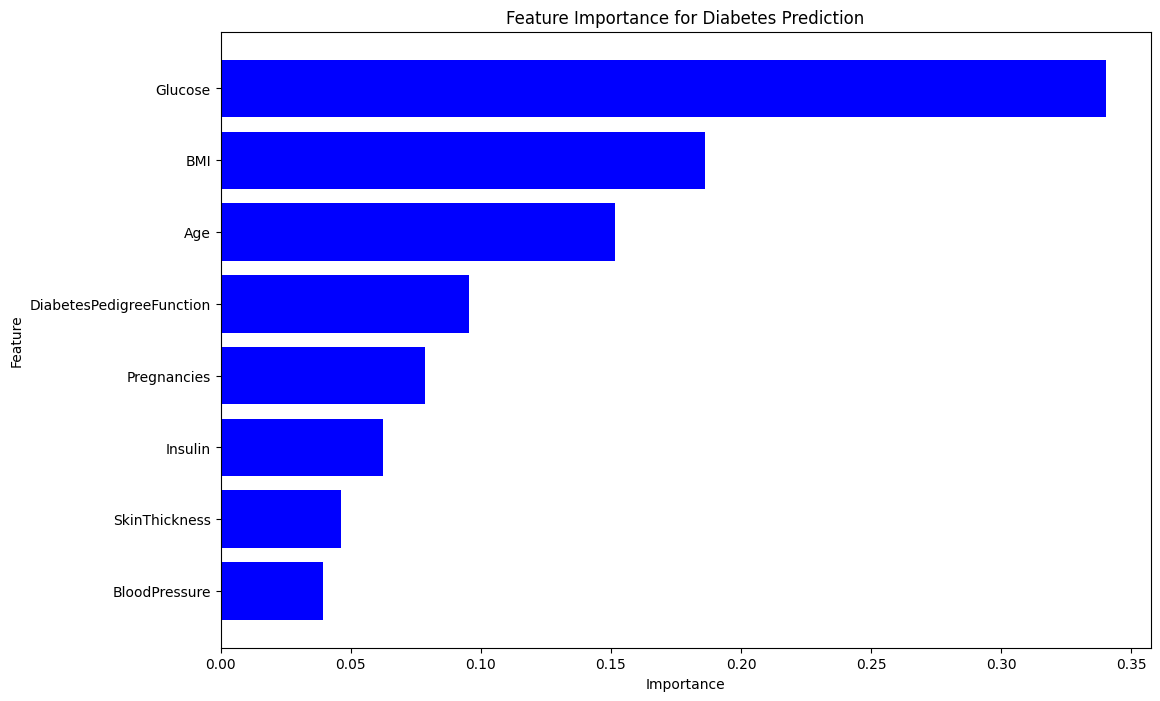

In [147]:
best_rf = RandomForestClassifier(n_estimators=50, **grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

feature_importances = best_rf.feature_importances_
features = X_train.columns

importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Diabetes Prediction')
plt.gca().invert_yaxis()  # Самый важный признак сверху
plt.show()

Самый важный признак - уровень сахара в крови. Не удивительно :(

Ура, предпоследняя домашка! Житьжитьжить. Ассист, хорошего тебе дня вечера ночи и вкусного ужина

![Пример изображения](https://i.pinimg.com/564x/ba/26/b2/ba26b25eb4041866a5ff1e28a88b4940.jpg "Это пример изображения")